# Projeto de Classificaçãoo para Marinha do Brasil
### Autor: Natanael Junior (natmourajr@gmail.com)
Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM


## Bibliotecas e leitura de dados

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'

data_path             = os.getenv('OUTPUTDATAPATH')
main_analysis_path    = os.environ['SONAR_WORKSPACE']
log_analysis_path     = os.environ['PACKAGE_NAME']
result_analysis_path  = log_analysis_path+'/'+analysis_name
pictures_results_path = result_analysis_path+'/pictures_files'
files_results_path    = result_analysis_path+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag   = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))
    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'
    
    # correct format
    all_data = data
    all_trgt = trgt

Time to import all libraries: 2.59876251221e-05 seconds
Time to read data file: 1.04838418961 seconds


## Balanceamento de Classes
Os dados encontram-se desbalanceados. Com isso, os classificadores podem se especializar em uma classe (gerando mais SVs para a mesma) e não se especializar em outras

Acessados em 21/12/2016

https://svds.com/learning-imbalanced-classes/

http://www.cs.utah.edu/~piyush/teaching/ImbalancedLearning.pdf

http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

Para solucionar isso, a primeira solução é "criar" dados das classes com menos eventos de maneira aleatória. Outras soluções podem ser propostas posteriormente.

In [2]:
# Process data
# unbalanced data to balanced data with random data creation of small classes

# Same number of events in each class
qtd_events_biggest_class = 0
biggest_class_label = ''

for iclass, class_label in enumerate(class_labels):
    if sum(all_trgt==iclass) > qtd_events_biggest_class:
        qtd_events_biggest_class = sum(all_trgt==iclass)
        biggest_class_label = class_label
    print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

balanced_data = {}
balanced_trgt = {}

from Functions import DataHandler as dh
m_datahandler = dh.DataHandlerFunctions()

for iclass, class_label in enumerate(class_labels):
    if development_flag:
        class_events = all_data[all_trgt==iclass,:]
        if len(balanced_data) == 0:
            balanced_data = class_events[0:development_events,:]
            balanced_trgt = (iclass)*np.ones(development_events)
        else:
            balanced_data = np.append(balanced_data,
                                      class_events[0:development_events,:], 
                                      axis=0)
            balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
    else:
        if len(balanced_data) == 0:
            class_events = all_data[all_trgt==iclass,:]
            balanced_data = m_datahandler.CreateEventsForClass(
                class_events,qtd_events_biggest_class-(len(class_events)))
            balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
        else:
            class_events = all_data[all_trgt==iclass,:]
            created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                 qtd_events_biggest_class-
                                                                 (len(class_events))))
            balanced_data = np.append(balanced_data,created_events,axis=0)
            balanced_trgt = np.append(balanced_trgt,
                                      (iclass)*np.ones(created_events.shape[0]),axis=0)

all_data = balanced_data
all_trgt = balanced_trgt

# turn targets in sparse mode
from keras.utils import np_utils
trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


Using Theano backend.


## Definições do treinamento

Nessa célula temos os parâmetros do treinamento a ser realizado. No log, deve ficar armazenada a data do treinamento para a reconstrução dos resultados

In [26]:
%time

from sklearn import cross_validation

from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("Classification",'StackedAutoEncoder')

# Create a train information file
n_folds = 2
n_inits = 1
norm = 'mapstd'

# params for top sweep of first layer
top_min = 400
top_max = 400
top_step = 75

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

# top sweep
train_info['sweep_top_min'] = top_min
train_info['sweep_top_max'] = top_max
train_info['sweep_top_step'] = top_step

# divide data in train and test for novelty detection
print 'Dividing data in trn and tst'
CVO = cross_validation.StratifiedKFold(all_trgt, n_folds)
CVO = list(CVO)
train_info['CVO'] = CVO

train_info['topologic_anal_done'] = False
train_info['2nd_topologic_anal_done'] = False
train_info['train_done'] = False
train_info['results_done'] = False

train_info_name = result_analysis_path+'/output_files'+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs
Dividing data in trn and tst


['/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/output_files/2017_08_16_15_30_36_train_info.jbl']

In [27]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="Classification")
lastTrain = log_entries[np.max(log_entries.keys())]
print 'Last Train\nDate: {0}\nPackage: {1}\n'.format(lastTrain['date'],lastTrain['package'])
for ilog in log_entries.values():
    if ilog['package'] == analysis_name:
        print ilog

Last Train
Date: 2017_08_16_15_30_36
Package: StackedAutoEncoder

{'date': '2017_08_03_23_11_28', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_06_08_17_24', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_07_10_19_57', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_09_10_28_47', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_09_19_37_56', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_14_11_15_21', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_14_11_27_10', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_14_14_22_13', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_15_11_06_13', 'package': 'StackedAutoEncoder'}
{'date': '2017_08_16_15_30_36', 'package': 'StackedAutoEncoder'}


In [31]:
# Read Information of Train Info File
choose_date = '2017_08_16_15_30_36'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/output_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    print 'StackedAutoEncoder Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Inits: %i'%(train_info['n_inits'])
    print 'Top Sweep: min %i, max %i, step %i'%(train_info['sweep_top_min'],
                                                train_info['sweep_top_max'],
                                                train_info['sweep_top_step'])
    print 'Norm: %s'%train_info['norm']
    if train_info['topologic_anal_done']:
        print 'Topological Analysis Done: True'
    else:
        print 'Topological Analysis Done: False'
    if train_info['train_done']:
        print 'Train Done: True'
    else:
        print 'Train Done: False'
    if train_info['results_done']:
        print 'Extract Results: True'
    else:
        print 'Extract Results: False'

Analysing train performed in 2017_08_16_15_30_36 and for StackedAutoEncoder analysis
StackedAutoEncoder Train Info File
Date: 2017_08_16_15_30_36
Number of Folds: 2
Number of Inits: 1
Top Sweep: min 400, max 400, step 75
Norm: mapstd
Topological Analysis Done: True
Train Done: False
Extract Results: False


## Stacked AutoEncoder Analysis


First step: sweep the number of neurons in each layer of SAE and vary number of layers


In [ ]:
# SAE parameters extraction
# first layer

%time

from sklearn import preprocessing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks

from Functions import PreProcessing as preproc

# Parameters of Optimizer Algorithm
learning_rate = 0.001
beta_1       = 0.9
beta_2       = 0.999
epsilon      = 1e-08
# Parameters of the training
n_epochs    = 800
batch_size   = 512
train_verbose = True
verbose = True
patience = 100

models = {}
trn_descs = {}
losses = np.zeros((train_info['n_folds'],
                   len(range(train_info['sweep_top_min'], 
                             train_info['sweep_top_max']+1,
                             train_info['sweep_top_step']))))

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/output_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if train_info['topologic_anal_done']:
        print 'Topological Analysis of first layer is done, just analyse it'
        continue
    
    trn_params = preproc.TrnParams(learning_rate=learning_rate,verbose=verbose,
                                   train_verbose=train_verbose, n_epochs=n_epochs, batch_size=batch_size)
    
    for ifold in range(train_info['n_folds']):
        train_id, test_id = train_info['CVO'][ifold]
        
        models[ifold] = {}
        trn_descs[ifold] = {}
        
        # normalize data based in train set
        if train_info['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(all_data[train_id,:])
        
        norm_all_data = scaler.transform(all_data)
        
        neuron_count = 0
        for ineuron in range(train_info['sweep_top_min'], 
                             train_info['sweep_top_max']+1, 
                             train_info['sweep_top_step']):
            if ineuron == 0:
                ineuron = 1
            
            best_init = 0
            best_loss = 999
            
            for i_init in range(train_info['n_inits']):
                print ('Fold: %i of %i, neuron: %i of %i, init: %i of %i'%
                       (ifold+1, train_info['n_folds'],ineuron, train_info['sweep_top_max'],
                        i_init+1, train_info['n_inits']))

                # create model
                model = Sequential()
                model.add(Dense(ineuron, input_dim=norm_all_data.shape[1], init='uniform'))
                model.add(Activation('softplus'))
                model.add(Dense(norm_all_data.shape[1], init='uniform')) 
                model.add(Activation('tanh'))
                
                adam = Adam(lr=trn_params.learning_rate, 
                          beta_1=beta_1,
                          beta_2=beta_2, 
                          epsilon=epsilon)
                
                model.compile(loss='mean_squared_error', 
                              optimizer=adam,
                              metrics=['mean_absolute_error'])

                # Early Stopping
                earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=patience, 
                                                        verbose= trn_params.train_verbose, 
                                                        mode='auto')
                # train model
                trn_desc = model.fit(norm_all_data[train_id], 
                                     norm_all_data[train_id], 
                                     nb_epoch=trn_params.n_epochs, 
                                     batch_size=trn_params.batch_size,
                                     callbacks=[earlyStopping], 
                                     verbose=trn_params.verbose,
                                     validation_data=(norm_all_data[test_id],
                                                      norm_all_data[test_id]),
                                     shuffle=True)
                
                # check if train was the best one
                if i_init == 0:
                    trn_descs[ifold][ineuron] = trn_desc
                    models[ifold][ineuron] = model
                    losses[ifold,neuron_count] = np.min(trn_desc.history['val_loss'])
                else:
                    if np.min(trn_desc.history['val_loss']) < best_loss:
                        best_init = i_init
                        best_loss = np.min(trn_desc.history['val_loss'])
                        models[ifold][ineuron] = model
                        trn_desc[ifold] = trn_desc
                        losses[ifold,neuron_count]= np.min(trn_desc.history['val_loss'])
                        
            neuron_count = neuron_count+1
    print 'Train done'
    # saving file
    
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses.jbl'
    joblib.dump([losses],top_info_name,compress=9)
    
    for ifold in range(train_info['n_folds']):
        for ineuron in range(top_min, top_max+1, top_step):
            if ineuron == 0:
                ineuron = 1
            model_name = (result_analysis_path+'/output_files'+'/'+
                          choose_date+'_model_fold'+str(ifold)+
                          '_neuron'+str(ineuron)+'.h5')
            models[ifold][ineuron].save(model_name)
            
    train_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_train_info.jbl'

    train_info['topologic_anal_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
StackedAutoEncoder analysis performed in 2017_08_16_15_30_36 and for StackedAutoEncoder analysis
Fold: 1 of 2, neuron: 400 of 400, init: 1 of 1
Train on 58704 samples, validate on 58704 samples
Epoch 1/800
58704/58704 [==============================] - 48s - loss: 0.6483 - mean_absolute_error: 0.6216 - val_loss: 0.4306 - val_mean_absolute_error: 0.5014
Epoch 2/800
58704/58704 [==============================] - 48s - loss: 0.3548 - mean_absolute_error: 0.4515 - val_loss: 0.3223 - val_mean_absolute_error: 0.4252
Epoch 3/800
58704/58704 [==============================] - 49s - loss: 0.2928 - mean_absolute_error: 0.4030 - val_loss: 0.2865 - val_mean_absolute_error: 0.3940
Epoch 4/800
58704/58704 [==============================] - 49s - loss: 0.2666 - mean_absolute_error: 0.3781 - val_loss: 0.2669 - val_mean_absolute_error: 0.3741
Epoch 5/800
58704/58704 [==============================] - 49s - loss: 0.2503 - mean_absolute_erro

58704/58704 [==============================] - 47s - loss: 0.1801 - mean_absolute_error: 0.2437 - val_loss: 0.1873 - val_mean_absolute_error: 0.2477
Epoch 58/800
58704/58704 [==============================] - 47s - loss: 0.1801 - mean_absolute_error: 0.2437 - val_loss: 0.1873 - val_mean_absolute_error: 0.2479
Epoch 59/800
58704/58704 [==============================] - 47s - loss: 0.1800 - mean_absolute_error: 0.2435 - val_loss: 0.1872 - val_mean_absolute_error: 0.2476
Epoch 60/800
58704/58704 [==============================] - 47s - loss: 0.1800 - mean_absolute_error: 0.2434 - val_loss: 0.1871 - val_mean_absolute_error: 0.2473
Epoch 61/800
58704/58704 [==============================] - 47s - loss: 0.1799 - mean_absolute_error: 0.2433 - val_loss: 0.1871 - val_mean_absolute_error: 0.2473
Epoch 62/800
58704/58704 [==============================] - 47s - loss: 0.1799 - mean_absolute_error: 0.2431 - val_loss: 0.1871 - val_mean_absolute_error: 0.2472
Epoch 63/800
58704/58704 [===============

In [ ]:
# to reset analysis
#train_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_train_info.jbl'

#train_info['norm'] = 'mapstd'
#joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
StackedAutoEncoder analysis performed in 2017_08_16_15_30_36 and for StackedAutoEncoder analysis


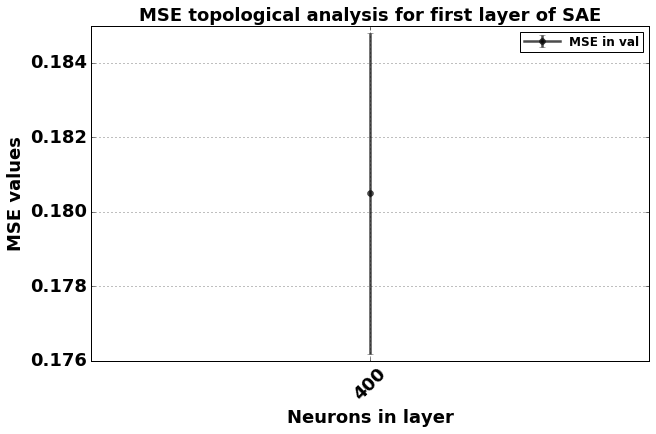

In [32]:
# Topological analysis
# SAE parameters extraction
%time

from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks

from keras.models import load_model

from Functions import PreProcessing as preproc


for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/output_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if not train_info['topologic_anal_done']:
        continue
        
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses.jbl'
    [losses]= joblib.load(top_info_name)
    
    import matplotlib.pyplot as plt
    %matplotlib inline  

    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.borderpad'] = 0.3
    
    fig1 = plt.figure(figsize=(10,6))

    xtick = range(train_info['sweep_top_min'], train_info['sweep_top_max']+1, train_info['sweep_top_step'])
    if train_info['sweep_top_min'] == 0:
        xtick[0] = 1
    plt.errorbar(xtick,
                  np.mean(losses,axis=0),
                  np.std(losses,axis=0),fmt='o-',
                  color='k',alpha=0.7,linewidth=2.5, label='MSE in val')
    plt.xticks(xtick,rotation=45)
    plt.xlim([train_info['sweep_top_min']-1,train_info['sweep_top_max']+1])
    plt.title('MSE topological analysis for first layer of SAE',fontsize=18, fontweight='bold')
    plt.xlabel('Neurons in layer',fontsize=18, fontweight='bold')
    plt.ylabel('MSE values',fontsize=18, fontweight='bold')

    plt.legend()
    plt.grid()
    
    # Save results
    if train_info['topologic_anal_done']:
        file_name = '%s_%s_mse_top_sweep_%i_%i_%i.png'%(choose_date,
                                                    analysis_name,
                                                    train_info['sweep_top_min'],
                                                    train_info['sweep_top_max'],
                                                    train_info['sweep_top_step'])
            
        plt.savefig(pictures_results_path+'/'+file_name)
    

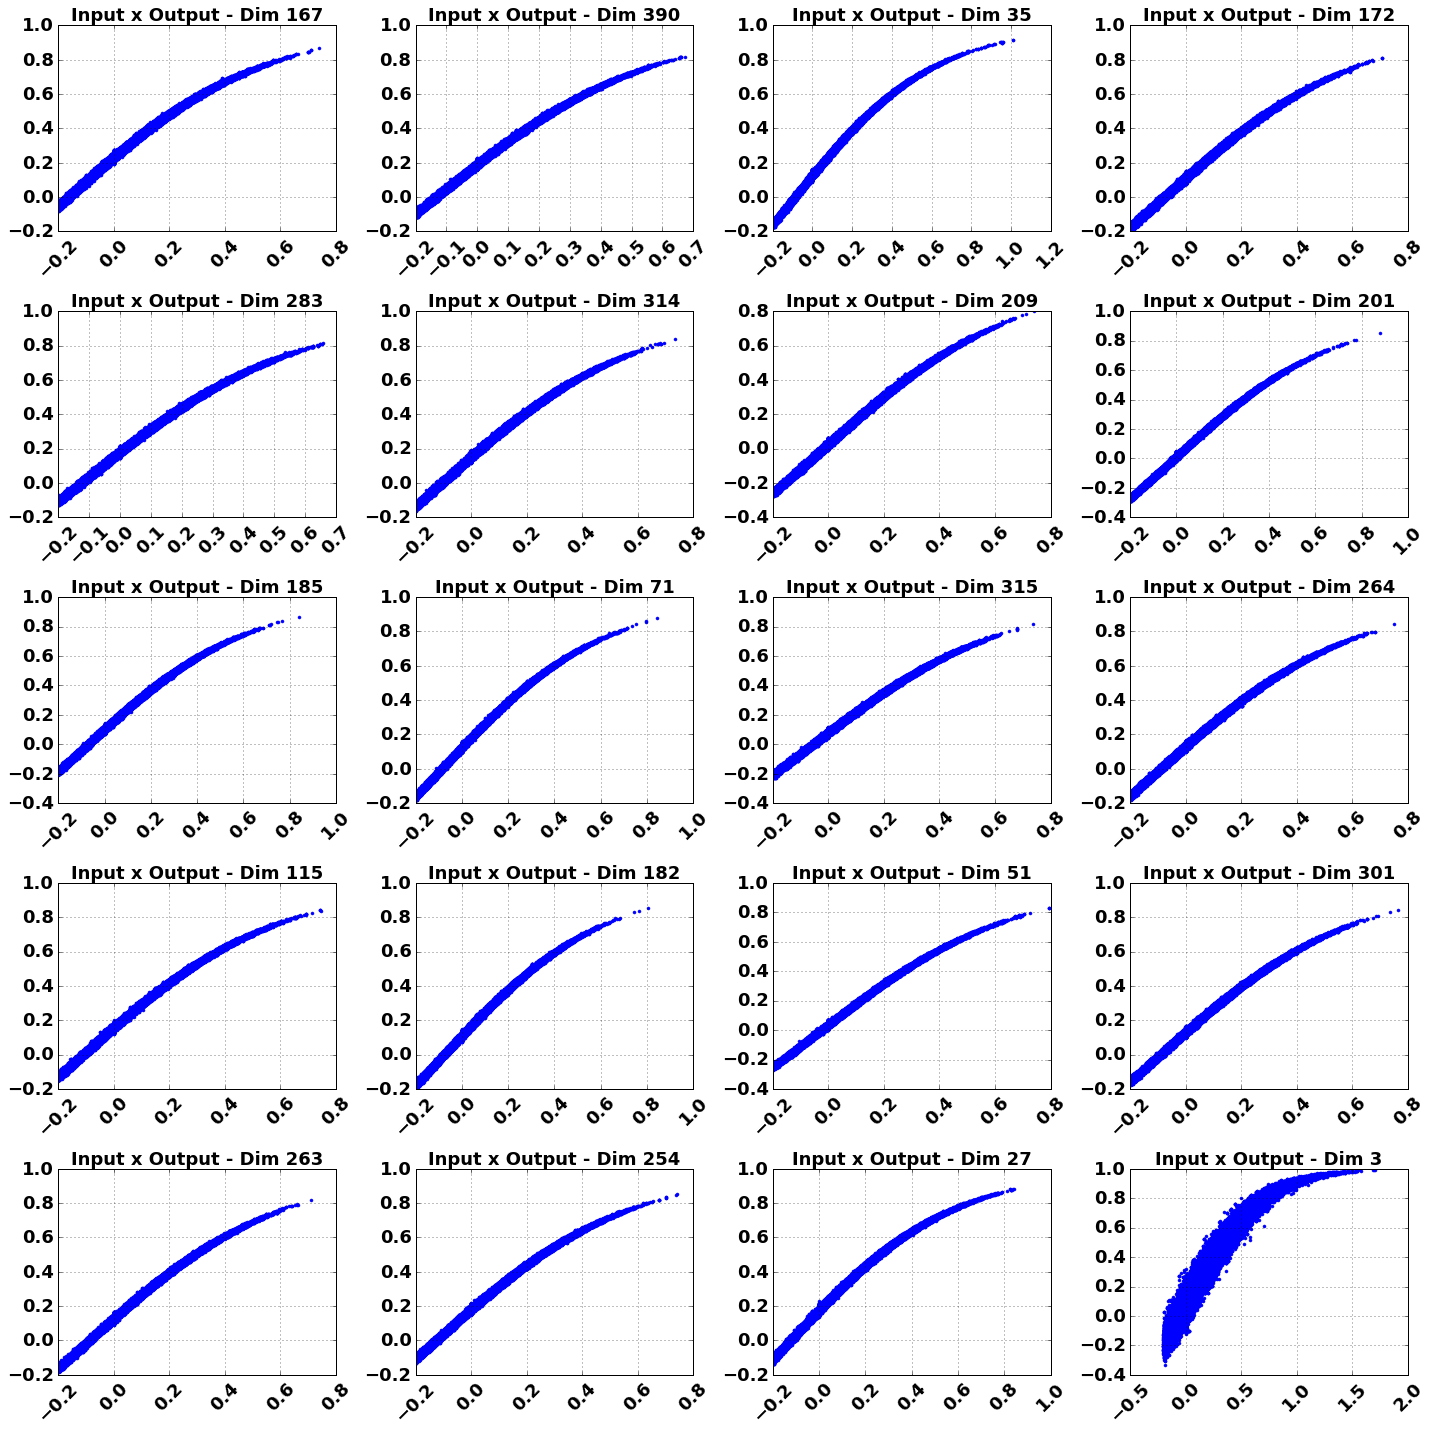

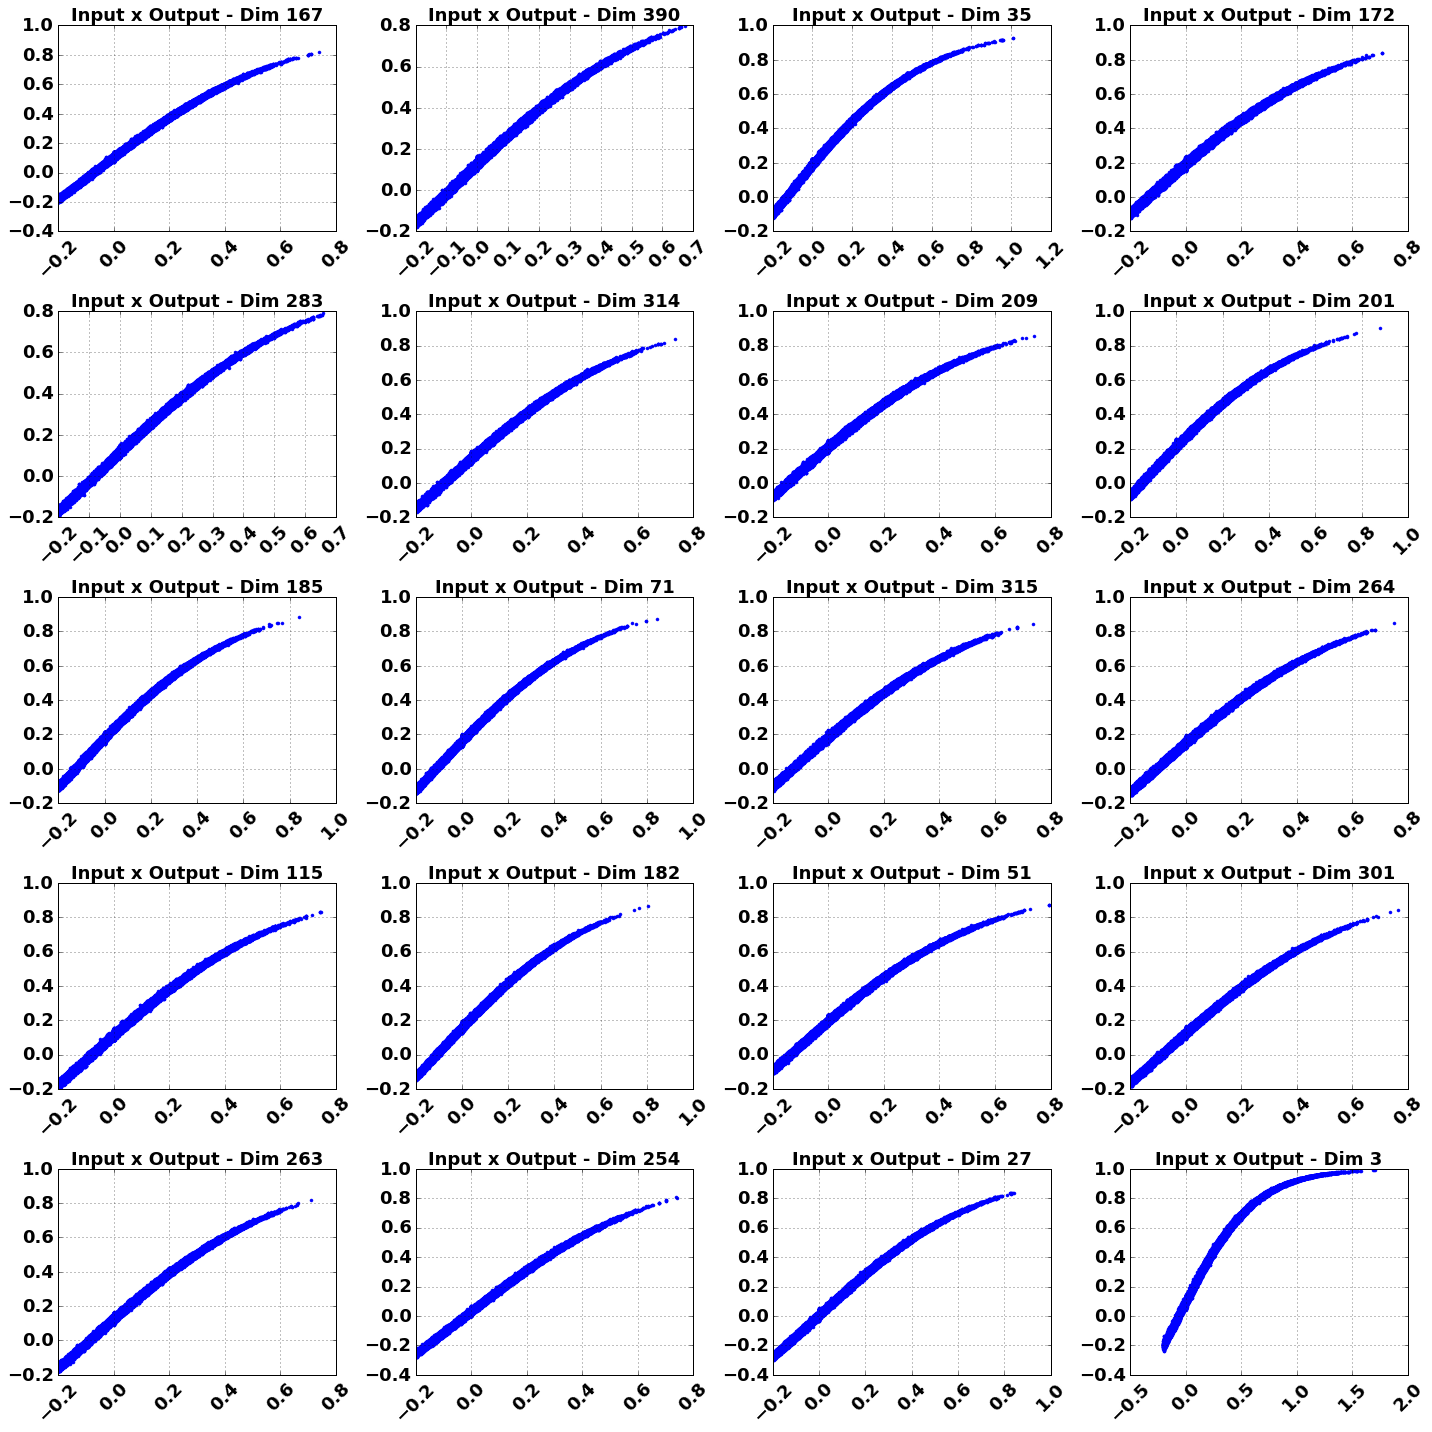

In [34]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# Number of neurons at first layer
ineuron = 400 

models = {}
outputs = {}
mean = {}
indexes = {}

diffSquared = np.zeros([train_info['n_folds'],all_data.shape[0],all_data.shape[1]])

for ifold in range(train_info['n_folds']):
    train_id, test_id = train_info['CVO'][ifold]
    
     # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])
    norm_all_data = scaler.transform(all_data)
    
    # load model
    model_name = (result_analysis_path+'/output_files'+'/'+
                          choose_date+'_model_fold'+str(ifold)+
                          '_neuron'+str(ineuron)+'.h5')
    models[ifold]  = load_model(model_name)
    
    outputs[ifold] = models[ifold].predict(all_data) 

for ifold in range(train_info['n_folds']):
    train_id, test_id = train_info['CVO'][ifold]
    diffSquared[ifold] = np.power((all_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(train_info['n_folds']):
    points = all_data.shape[0]
    
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
    for choose_index in range(20):
        train_id, test_id = train_info['CVO'][ifold]

        plt.rcParams['font.weight'] = 'bold'
        plt.rcParams['xtick.labelsize'] = 18
        plt.rcParams['ytick.labelsize'] = 18
        plt.rcParams['legend.numpoints'] = 1
        plt.rcParams['legend.handlelength'] = 3
        plt.rcParams['legend.borderpad'] = 0.3
        ax = plt.subplot(5,4,choose_index+1)
        ax.plot(all_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        plt.legend()
        plt.grid()    
        
    # Save results
    if train_info['topologic_anal_done']:
        file_name = '%s_%s_inputxoutput_top_sweep_%i_%i_%i_fold_%i.png'%(choose_date,
                                                    analysis_name,
                                                    train_info['sweep_top_min'],
                                                    train_info['sweep_top_max'],
                                                    train_info['sweep_top_step'],
                                                    ifold)

        plt.savefig(pictures_results_path+'/'+file_name)

In [ ]:
trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
print trgt_sparse

In [ ]:
# load first layer model and train a classifier 
# 400 -> X -> 4 where X is number of neurons in the first layer
ineuron = 400

nn_trained = 0 

# Parameters of Optimizer Algorithm
learning_rate = 0.005
beta_1       = 0.9
beta_2       = 0.999
epsilon      = 1e-08
# Parameters of the training
n_epochs    = 800
batch_size   = 1024
train_verbose = True
verbose = True

if not train_info['train_done'] and train_info['topologic_anal_done']:  
    
    # Read train info file
    train_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_train_info.jbl'

    [train_info] = joblib.load(train_info_name)

    trn_params = preproc.TrnParams(learning_rate= learning_rate, verbose=verbose,
                                   train_verbose=train_verbose, n_epochs=n_epochs)
    
    # Transform trgt_sparse to [-1,1]

    #for ifold in range(train_info['n_folds']):
    ifold = 1
    train_id, test_id = train_info['CVO'][ifold]   

    classifiers = []
    trn_desc = {}

    first_layer_model_name = (result_analysis_path+'/output_files'+'/'+
                              choose_date+'_model_fold'+str(ifold)+
                              '_neuron'+str(ineuron)+'.h5')

    first_layer_model = load_model(first_layer_model_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])
    norm_all_data = scaler.transform(all_data)

    print 'Train Process for %i Fold of %i Folds'%(ifold+1,train_info['n_folds'] )
    # get the output of an intermediate layer
    from keras import backend as K

    # with a Sequential model
    #get_layer_output = K.function([first_layer_model.layers[0].input],
    #                              [first_layer_model.layers[1].output])
    #proj_all_data = get_layer_output([norm_all_data])[0]

    first_layer = first_layer_model.layers[0]
    first_layer_weights = first_layer.get_weights()

    best_init = 0
    best_loss = 999

    for i_init in range(train_info['n_inits']):

        print 'Train Process for %i Fold of %i Folds'%(ifold+1,train_info['n_folds'] )

        # create model
        model = Sequential()
        model.add(Dense(ineuron, input_dim=all_data.shape[1], weights=first_layer_weights, trainable=True))
        model.add(Activation('tanh'))
        model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
        model.add(Activation('softmax'))

        adam = Adam(lr=trn_params.learning_rate, 
                  beta_1=beta_1,
                  beta_2=beta_2, 
                  epsilon=epsilon)

        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])


        # Early Stopping
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=100, 
                                                verbose=trn_params.train_verbose, 
                                                mode='auto')
        # train model
        init_trn_desc = model.fit(all_data[train_id], 
                             trgt_sparse[train_id], 
                             nb_epoch=trn_params.n_epochs, 
                             batch_size=trn_params.batch_size,
                             callbacks=[earlyStopping], 
                             verbose=trn_params.verbose,
                             validation_data=(all_data[test_id],
                                              trgt_sparse[test_id]),
                             shuffle=True)

        # check if train was the best one
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
                best_init = i_init
                best_loss = np.min(init_trn_desc.history['val_loss'])
                classifiers = model
                trn_desc['epochs'] = init_trn_desc.epoch
                trn_desc['acc'] = init_trn_desc.history['acc']
                trn_desc['loss'] = init_trn_desc.history['loss']
                trn_desc['val_loss'] = init_trn_desc.history['val_loss']
                trn_desc['val_acc'] = init_trn_desc.history['val_acc']

 # save modeldate
    base_name = files_results_path+'/'+choose_date+'_'
    save_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    classifiers.save(save_file_name)
    save_file_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    train_info['train_done'] = True
    n_neurons = ineuron
    joblib.dump([train_info,n_neurons,trn_desc],save_file_name,compress=9)
    train_info_name = files_results_path+'/'+choose_date+'_train_info.jbl'
    joblib.dump([train_info],train_info_name,compress=9)    
    print 'Train done'
else:
    if not train_info['topologic_anal_done']:
        print 'Topological Analysis of first layer is not done!!!'
    else: 
        print 'Train %s has already been done!!! Do the analysis'%choose_date

Train Process for 2 Fold of 2 Folds
Train Process for 2 Fold of 2 Folds
Train on 58704 samples, validate on 58704 samples
Epoch 1/800
58704/58704 [==============================] - 62s - loss: 0.1229 - acc: 0.7286 - val_loss: 0.1694 - val_acc: 0.6525
Epoch 2/800
58704/58704 [==============================] - 78s - loss: 0.1128 - acc: 0.7686 - val_loss: 0.1694 - val_acc: 0.6561
Epoch 3/800
58704/58704 [==============================] - 71s - loss: 0.1088 - acc: 0.7786 - val_loss: 0.1567 - val_acc: 0.6817
Epoch 4/800
58704/58704 [==============================] - 67s - loss: 0.1064 - acc: 0.7836 - val_loss: 0.1643 - val_acc: 0.6672
Epoch 5/800
58704/58704 [==============================] - 65s - loss: 0.1050 - acc: 0.7872 - val_loss: 0.1600 - val_acc: 0.6759
Epoch 6/800
33040/58704 [===============>..............] - ETA: 26s - loss: 0.1047 - acc: 0.7877

In [ ]:
# To Reset training
#train_info['train_done'] = False
#train_info_name = files_results_path+'/'+date+'_train_info.jbl'
#joblib.dump([train_info],train_info_name,compress=9)    

#train_info['train_done'] = False
#train_info_name = files_results_path+'/'+choose_date+'_train_info.jbl'
#joblib.dump([train_info],train_info_name,compress=9)

##    Analysis of the model trained

In [ ]:
analysisName = 'mse'

# plot train updates
import matplotlib.pyplot as plt
%matplotlib inline  

for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig1 = plt.figure(figsize=(10,6))

    base_name = files_results_path+'/'+choose_date+'_'

    load_file_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(load_file_name)

    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    if model.loss == 'mean_squared_error':
        cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()
    
    # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

In [ ]:
base_name = files_results_path+'/'+choose_date+'_'
mean_val_acc = {}
variance_val_acc = {}

print '\tMean of val_acc\t\tVariance of val_acc'
for ifold in range(train_info['n_folds']):
    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)
    
    mean_val_acc[ifold] = np.mean(trn_desc['val_acc'])
    variance_val_acc[ifold] = np.var(trn_desc['val_acc'])
    print 'Fold %i: %.2f%%\t\t\t%.2f%%'%(ifold,    100*mean_val_acc[ifold], 100*variance_val_acc[ifold])


In [ ]:
from sklearn import preprocessing

analysisName = 'confusion_matrix'

import matplotlib.pyplot as plt
%matplotlib inline  
for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    train_id, test_id = train_info['CVO'][ifold]

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)

    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    output = model.predict(norm_all_data)
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
    
    # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

In [ ]:
analysisName = 'histogram'

import matplotlib.pyplot as plt
%matplotlib inline  

for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

    labels = class_labels.values()

    # read trained model

    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
    
    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)

    output = model.predict(norm_all_data)

    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse.shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=1)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
       # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)


In [ ]:
analysisName = 'kernel_density'

import matplotlib.pyplot as plt
%matplotlib inline  
for ifold in range(train_info['n_folds']):
    print "Results for fold #%i"%ifold
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)

    labels = class_labels.values()

    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
    
    # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)
    
    output = model.predict(norm_all_data)

    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse.shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()
   # Save results
    if train_info['train_done']:
        if development_flag:
            file_name = '%s_%s_%i_neurons_fold_%i_development.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
        else:
            file_name = '%s_%s_%i_neurons_fold_%i.png'%(choose_date,
                                                    analysisName,
                                                    n_neurons,#train_info['n_neurons'],
                                                    ifold)
            
        plt.savefig(pictures_results_path+'/'+file_name)

In [ ]:
# Classification Report
import keras
from keras import backend as K
import sklearn.metrics

print 'Showing results for train performed on %s:'%choose_date
for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    print "Results for Fold #%i"%ifold
    # read trained model
    base_name = files_results_path+'/'+choose_date+'_'

    train_info_name = base_name+"_fold_%i_trn_desc.jbl"%(ifold)
    [train_info,n_neurons,trn_desc] = joblib.load(train_info_name)

    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])

    norm_all_data = scaler.transform(all_data)
    
     # load weights into new model
    from keras.models import load_model
    load_file_name = base_name+"_fold_%i_classifier.h5"%(ifold)
    model = load_model(load_file_name)
    
    output = model.predict(norm_all_data[test_id])
    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
    #print sklearn.metrics.classification_report(trgt_sparse[test_id], np.round(output), target_names=class_labels.values())

## Sweep the number of neurons on the second hidden layer

In [ ]:
# SAE parameters extraction
# second layer

top_min = 0
top_max = 300
top_step = 75

%time

from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks

from Functions import PreProcessing as preproc

models = {}
trn_descs = {}
losses = np.zeros((train_info['n_folds'],
                   len(range(top_min, 
                             top_max+1,
                             top_step))))

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/output_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if train_info['2nd_topologic_anal_done'] is not None:
        if train_info['2nd_topologic_anal_done']:
            print 'Topological Analysis is done, just analyse it'
            continue
    
    trn_params = preproc.TrnParams(learning_rate= 0.005,verbose=True,
                                   train_verbose=True, n_epochs=500, batch_size=1024)
    
    for ifold in range(train_info['n_folds']):
        train_id, test_id = train_info['CVO'][ifold]
        
        ineuron = 450

        model_name = (result_analysis_path+'/output_files'+'/'+
                      choose_date+'_model_fold'+str(ifold)+
                      '_neuron'+str(ineuron)+'.h5')
            

        first_layer_model = load_model(model_name)
        
        models[ifold] = {}
        trn_descs[ifold] = {}
        
        # normalize data based in train set
        if train_info['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(all_data[train_id,:])
        
        norm_all_data = scaler.transform(all_data)
        
        neuron_count = 0
        for ineuron in range(top_min, 
                             top_max+1, 
                             top_step):
            if ineuron == 0:
                ineuron = 1
            
            best_init = 0
            best_loss = 999
            
            for i_init in range(train_info['n_inits']):
                print ('Fold: %i of %i, neuron: %i of %i, init: %i of %i'%
                       (ifold+1, train_info['n_folds'],ineuron, top_max,
                        i_init+1, train_info['n_inits']))

                # create model
                model = Sequential()
                model.add(Dense(ineuron, input_dim=norm_all_data.shape[1], init='uniform'))
                model.add(Activation('softplus'))
                model.add(Dense(norm_all_data.shape[1], init='uniform')) 
                model.add(Activation('tanh'))
                
                adam = Adam(lr=trn_params.learning_rate, 
                          beta_1=0.9,
                          beta_2=0.999, 
                          epsilon=1e-08)
                
                model.compile(loss='mean_squared_error', 
                              optimizer=adam,
                              metrics=['mean_absolute_error'])


                # Early Stopping
                earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=25, 
                                                        verbose=trn_params.train_verbose, 
                                                        mode='auto')
                # train model
                trn_desc = model.fit(norm_all_data[train_id], 
                                     norm_all_data[train_id], 
                                     nb_epoch=trn_params.n_epochs, 
                                     batch_size=trn_params.batch_size,
                                     callbacks=[earlyStopping], 
                                     verbose=trn_params.verbose,
                                     validation_data=(norm_all_data[test_id],
                                                      norm_all_data[test_id]),
                                     shuffle=True)
                
                # check if train was the best one
                if i_init == 0:
                    trn_descs[ifold][ineuron] = trn_desc
                    models[ifold][ineuron] = model
                    losses[ifold,neuron_count] = np.min(trn_desc.history['val_loss'])
                else:
                    if np.min(trn_desc.history['val_loss']) < best_loss:
                        best_init = i_init
                        best_loss = np.min(trn_desc.history['val_loss'])
                        models[ifold][ineuron] = model
                        trn_desc[ifold] = trn_desc
                        losses[ifold,neuron_count]= np.min(trn_desc.history['val_loss'])
                        
            neuron_count = neuron_count+1
                
        
    
    print 'Train done'
    # saving file
    
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses_second_layer.jbl'
    joblib.dump([losses],top_info_name,compress=9)
    
    for ifold in range(train_info['n_folds']):
        for ineuron in range(top_min, top_max+1, top_step):
            if ineuron == 0:
                ineuron = 1
            model_name = (result_analysis_path+'/output_files'+'/'+
                          choose_date+'_model_fold'+str(ifold)+
                          '_neuron'+str(ineuron)+'.h5')
            models[ifold][ineuron].save(model_name)
    
            
    train_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_train_info_second_layer.jbl'

    train_info['2nd_topologic_anal_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

In [ ]:
# Topological analysis
# SAE parameters extraction
%time

from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks

from keras.models import load_model

from Functions import PreProcessing as preproc


for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/output_files/%s_train_info_second_layer.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if not train_info['topologic_anal_done']:
        continue
        
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses_second_layer.jbl'
    [losses]= joblib.load(top_info_name)
    
    import matplotlib.pyplot as plt
    %matplotlib inline  

    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.borderpad'] = 0.3
    
    fig1 = plt.figure(figsize=(10,6))

    xtick = range(top_min, top_max+1, top_step)
    if train_info['sweep_top_min'] == 0:
        xtick[0] = 1
    plt.errorbar(xtick,np.mean(losses,axis=0),np.std(losses,axis=0),fmt='o-',color='k',alpha=0.7,linewidth=2.5,
                 label='MSE in val')
    plt.xticks(xtick,rotation=45)
    plt.xlim([top_min-1,top_max+1])
    plt.title('MSE topological analysis for second layer of SAE',fontsize=18, fontweight='bold')
    plt.xlabel('Neurons in layer',fontsize=18, fontweight='bold')
    plt.ylabel('MSE values',fontsize=18, fontweight='bold')

    plt.legend()
    plt.grid()
    
    # Save results
    if train_info['topologic_anal_done']:
        file_name = '%s_%s_mse_top_sweep_second_layer_%i_%i_%i.png'%(choose_date,
                                                    analysis_name,
                                                    top_min,
                                                    top_max,
                                                    top_step)
            
        plt.savefig(pictures_results_path+'/'+file_name)
    